In [21]:
import numpy as np
import pandas as pd

from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset
from stanscofi.training_testing import cv_training
from stanscofi.training_testing import weakly_correlated_split, random_simple_split, metrics_list
from stanscofi.validation import compute_metrics, plot_metrics
from stanscofi.validation import AUC, Rscore, MRR, RP, PrecisionK, RecallK, F1K, AP, MAP, DCGk, NDCGk, MeanRank, HRk, ERR

from benchscofi import ALSWR, DRRS, LRSSL, PMF, SCPMF, Constant, LogisticMF

In [2]:
random_state = 1234
decision_threshold = 0

In [3]:
# Dataset
dataset_di = load_dataset("TRANSCRIPT", "../data/")
dataset = Dataset(**dataset_di)

# dataset_di = load_dataset("PREDICT", "../data/")
# dataset = Dataset(**dataset_di)

dataset.summary();

----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 204 drugs and 116 diseases involved in at least one positive/negative rating
401 positive, 11 negative, 92151 unlabeled (including 0 unavailable) drug-disease ratings
Sparsity: 0.45 percent (on drugs/diseases with at least one known rating 1.74)
-----------------------------------
* Feature matrices:
# Drug features: 12096	Total #Drugs: 613
Missing features: 0.00 percent
# Disease features: 12096	Total #Disease: 151
Missing features: 0.00 percent
----------------------------------------------------------------------



In [4]:
test_size = 0.2
metric = "cosine"

# Random split
(train_folds, test_folds), _ = random_simple_split(
    dataset, test_size, metric=metric
)

# # Weakly correlated split
# (train_folds, test_folds), _ = weakly_correlated_split(
#     dataset,
#     test_size,
#     early_stop=1,
#     metric=metric,
#     verbose=True,
# )


In [5]:
train_dataset = dataset.subset(train_folds, subset_name="Train_" + "TRANSCRIPT")
test_dataset = dataset.subset(test_folds, subset_name="Test_" + "TRANSCRIPT")

In [6]:
print("Train dataset")
train_dataset.summary();
print("Test dataset")
test_dataset.summary();

Train dataset
----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 180 drugs and 101 diseases involved in at least one positive/negative rating
321 positive, 9 negative, 92233 unlabeled (including 18513 unavailable) drug-disease ratings
Sparsity: 0.36 percent (on drugs/diseases with at least one known rating 1.82)
-----------------------------------
* Feature matrices:
# Drug features: 12096	Total #Drugs: 613
Missing features: 0.00 percent
# Disease features: 12096	Total #Disease: 151
Missing features: 0.00 percent
----------------------------------------------------------------------

Test dataset
----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 63 drugs and 58 diseases involved in at least one positive/negative rating
80 positive, 2 negative, 92481 unlabeled (including 74050 unavailable) drug-disease ratings
Sparsity: 0.09 percent (on drugs/d

In [7]:
algo_params = {
    "PMF": {
        "reg": 0.01,
        "learning_rate": 0.5,
        "n_iters": 160,
        "n_factors": 15,
        "batch_size": 100,
    },
}

In [9]:
# Algorithm
model = PMF(algo_params["PMF"])

In [10]:
# Training
model.fit(train_dataset, random_state)

BPR: 100%|██████████| 160/160 [00:00<00:00, 1759.46it/s]


In [12]:
# Predictions
scores = model.predict_proba(test_dataset)
predictions = model.predict(scores, threshold=decision_threshold)

model.print_scores(scores)
model.print_classification(predictions)

* Scores
613 unique items, 151 unique users
Scores: Min: 1.000000	Mean: 1.000000	Median: 1.000000	Max: 1.000000	Std: 0.000000

* Classification
613 unique items, 151 unique users
Positive class: 18513, Negative class: 0



In [11]:
# For validation
k = 5
beta = 1
nsplits = 5
njobs = nsplits - 1

# Cross-validation
results = cv_training(
    Constant,
    algo_params,
    train_dataset,
    threshold=decision_threshold,
    metric="AUC",
    k=k,
    beta=beta,
    njobs=njobs,
    nsplits=nsplits,
    random_state=random_state,
    show_plots=False,
    verbose=True,
    cv_type="random",
    # cv_type="weakly_correlated"
)
model = results["models"][np.argmax(results["test_metric"])]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


<validation.compute_metrics> Computed on #users=151, 67 ignored (44 perc)
<validation.compute_metrics> Computed on #users=151, 67 ignored (44 perc)
<validation.compute_metrics> Computed on #users=151, 62 ignored (41 perc)
<validation.compute_metrics> Computed on #users=151, 62 ignored (41 perc)
<validation.compute_metrics> Computed on #users=151, 109 ignored (72 perc)
Crossvalidation step #2/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=151, 115 ignored (76 perc)
Crossvalidation step #4/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=151, 113 ignored (75 perc)
Crossvalidation step #3/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=151, 106 ignored (70 perc)
Crossvalidation step #1/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=151, 62 ignored (41 perc)
<validation.compute_metrics> Computed on #users=151, 109 ignored (

In [13]:
# Predictions
scores = model.predict_proba(test_dataset)
predictions = model.predict(scores, threshold=decision_threshold)

model.print_scores(scores)
model.print_classification(predictions)

* Scores
613 unique items, 151 unique users
Scores: Min: 1.000000	Mean: 1.000000	Median: 1.000000	Max: 1.000000	Std: 0.000000

* Classification
613 unique items, 151 unique users
Positive class: 18513, Negative class: 0



<validation.compute_metrics> Computed on #users=151, 94 ignored (62 perc)


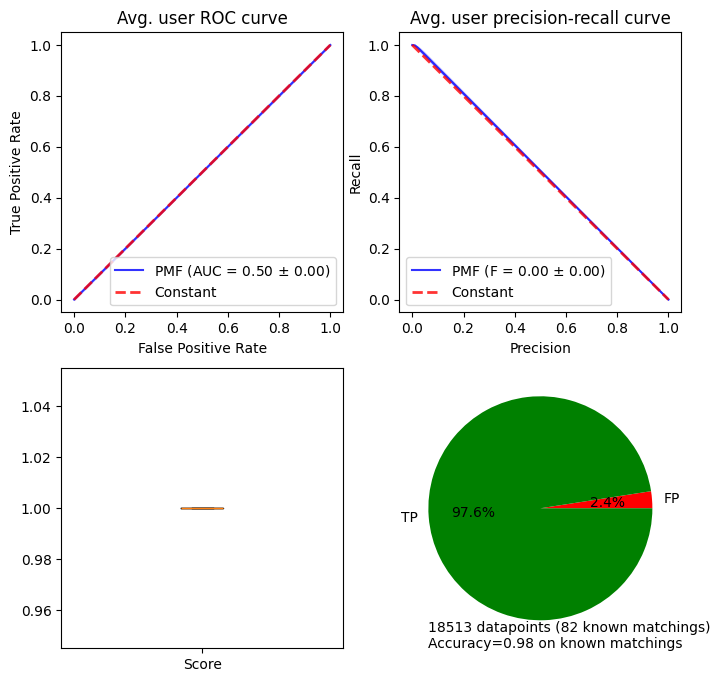

In [18]:

# Validation
# disease-wise metrics
metrics, plot_args = compute_metrics(
    scores, predictions, test_dataset, metrics=metrics_list, k=k, beta=beta, verbose=1
)
# run all metrics
plot_args.update({"model_name": "PMF", "figsize": (8, 8)})
plot_metrics(**plot_args)


In [20]:
# dataset-wide metrics
y_test = (test_dataset.folds.toarray() * test_dataset.ratings.toarray()).ravel()
y_test[y_test < 1] = 0

whole_metrics = [
    AUC(y_test, scores.toarray().ravel(), k, beta),
    Rscore(y_test, scores.toarray().ravel(), k, beta),
    MRR(y_test, scores.toarray().ravel(), k, beta),
    RP(y_test, scores.toarray().ravel(), k, beta),
    PrecisionK(y_test, scores.toarray().ravel(), k, beta),
    RecallK(y_test, scores.toarray().ravel(), k, beta),
    F1K(y_test, scores.toarray().ravel(), k, beta),
    AP(y_test, scores.toarray().ravel(), k, beta),
    MAP(y_test, scores.toarray().ravel(), k, beta),
    DCGk(y_test, scores.toarray().ravel(), k, beta),
    NDCGk(y_test, scores.toarray().ravel(), k, beta),
    MeanRank(y_test, scores.toarray().ravel(), k, beta),
    HRk(y_test, scores.toarray().ravel(), k, beta),
    ERR(y_test, scores.toarray().ravel(), k, beta),
]

results = pd.concat(
    (
        pd.DataFrame(
            [whole_metrics],
            index=["Value"],
            columns=[
                "AUC",
                "Rscore",
                "MRR",
                "RP",
                "PrecisionK",
                "RecallK",
                "F1K",
                "AP",
                "MAP",
                "DCGk",
                "NDCGk",
                "MeanRank",
                "HRk",
                "ERR",
            ],
        ).T,
        metrics,
    ),
    axis=1,
)

results.head()

,Value,Average,StandardDeviation
AUC,0.900344,0.500000,0.000000
Rscore,0.058822,0.000000,0.000000
MRR,0.002915,0.044145,0.075165
RP,0.004390,0.035818,0.057783
PrecisionK,0.000000,0.017544,0.056577
